# Get relevant gene list.

### Read and manipulate gtf file

In [4]:
import pandas as pd
import re
import numpy as np
import json

In [5]:
PATH_GTF_FILE = "/homes/mcolombari/AI_for_Bioinformatics_Project/Personal/gencode.v47.annotation.gtf"
OUTPUT_FOLDER_GENE_ID = "."
SAVE_GENE_ID = True

In [6]:
gtf = pd.read_csv(PATH_GTF_FILE, sep="\t", header=None, comment='#')

In [ ]:
# https://www.biostars.org/p/302441/

def remove_version(x):
    if '.' in x:
        return x.split('.')[0]
    return x

In [7]:
gtf.columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

parameters = ['gene_id', 'gene_type']
for p in parameters:
    gtf[p] = gtf['attribute'].apply(lambda x: re.findall(rf'{p} "([^"]*)"', x)[0] if rf'{p} "' in x else np.nan)

gtf.drop('attribute', axis=1, inplace=True)

gtf['gene_id'] = gtf['gene_id'].apply(remove_version)

print(gtf)

        seqname   source     feature  start    end score strand frame  \
0          chr1   HAVANA        gene  11121  24894     .      +     .   
1          chr1   HAVANA  transcript  11121  14413     .      +     .   
2          chr1   HAVANA        exon  11121  11211     .      +     .   
3          chr1   HAVANA        exon  12010  12227     .      +     .   
4          chr1   HAVANA        exon  12613  12721     .      +     .   
...         ...      ...         ...    ...    ...   ...    ...   ...   
4105480    chrM  ENSEMBL  transcript  15888  15953     .      +     .   
4105481    chrM  ENSEMBL        exon  15888  15953     .      +     .   
4105482    chrM  ENSEMBL        gene  15956  16023     .      -     .   
4105483    chrM  ENSEMBL  transcript  15956  16023     .      -     .   
4105484    chrM  ENSEMBL        exon  15956  16023     .      -     .   

                   gene_id gene_type  
0        ENSG00000290825.2    lncRNA  
1        ENSG00000290825.2    lncRNA  
2     

In [8]:
print(gtf.columns)

Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_type'],
      dtype='object')


In [9]:
gtf_pc = gtf[gtf['gene_type'] == 'protein_coding']
print(gtf_pc)

        seqname   source      feature  start    end score strand frame  \
2486       chr1   HAVANA         gene  65419  71585     .      +     .   
2487       chr1   HAVANA   transcript  65419  71585     .      +     .   
2488       chr1   HAVANA         exon  65419  65433     .      +     .   
2489       chr1   HAVANA         exon  65520  65573     .      +     .   
2490       chr1   HAVANA          CDS  65565  65573     .      +     0   
...         ...      ...          ...    ...    ...   ...    ...   ...   
4105474    chrM  ENSEMBL         gene  14747  15887     .      +     .   
4105475    chrM  ENSEMBL   transcript  14747  15887     .      +     .   
4105476    chrM  ENSEMBL         exon  14747  15887     .      +     .   
4105477    chrM  ENSEMBL          CDS  14747  15887     .      +     0   
4105478    chrM  ENSEMBL  start_codon  14747  14749     .      +     0   

                   gene_id       gene_type  
2486     ENSG00000186092.7  protein_coding  
2487     ENSG00000186

### Save Gene id relative to the protein coding

In [10]:
gtf_pc_set = set(gtf_pc['gene_id'].to_list())
print(len(gtf_pc_set))

20092


Value in output match with the stimated gene with are proteine coding.
source: [link](https://www.genome.gov/genetics-glossary/Gene#:~:text=And%20genes%20are%20the%20part,of%20the%20entire%20human%20genome.)

In [11]:
if SAVE_GENE_ID:
    with open(OUTPUT_FOLDER_GENE_ID + "/" + 'gene_id_protein_coding.json', 'w', encoding='utf-8') as f:
        json.dump(list(gtf_pc_set), f, ensure_ascii=False, indent=4) 

# Actual proprocessing

### Now parse load the data and parse it

In [12]:
import torch
import os

In [13]:
PATH_FOLDER_GENE = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/GeneExpression"
PATH_CASE_ID_STRUCTURE = "./case_id_and_structure.json"

In [14]:
with open(PATH_CASE_ID_STRUCTURE, 'r') as file:
    file_parsed = json.load(file)

In [15]:
file_to_case_id = dict((file_parsed[k]['files']['gene'], k) for k in file_parsed.keys())
file_to_os = dict((file_parsed[k]['files']['gene'], file_parsed[k]['os']) for k in file_parsed.keys())

Some resources to understand which feature to use:
- [Doc GDC](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Expression_mRNA_Pipeline/#introduction)

In [16]:
datastructure = pd.DataFrame(columns=['case_id', 'os', 'values'])

# All possibilitys.
# feature_to_save = [
#     'unstranded', 'stranded_first', 'stranded_second',
#     'tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded'
# ]
feature_to_save = ['tpm_unstranded']

index = 0
# Now explore data path to get the right files
for root, dirs, files in os.walk(PATH_FOLDER_GENE):
    for dir in dirs:
        for root, dirs, files in os.walk(PATH_FOLDER_GENE + "/" + dir):
            for file in files:
                if file in file_to_case_id.keys():
                    parsed_file = pd.read_csv(PATH_FOLDER_GENE + "/" + dir + "/" + file,
                                              sep='\t', header=0, skiprows=lambda x: x in [0, 2, 3, 4, 5])
                    parsed_file = parsed_file[['gene_id'] + feature_to_save]

                    # Now specify columns type.
                    convert_dict = dict([(k, float) for k in feature_to_save])
                    convert_dict['gene_id'] = str
                    parsed_file = parsed_file.astype(convert_dict)
                    
                    # They actually don't match.
                    # So the 'gene_type' in the dataset don't match the in the gtf file.
                    # So i'm gonna use as the right reference the gtf file.

                    # parsed_file = parsed_file[parsed_file['gene_type'] == 'protein_coding']
                    # if not set(parsed_file['gene_id']).issubset(gtf_pc_set):
                    #     raise Exception("List of coding genes don't match.")

                    parsed_file = parsed_file[parsed_file['gene_id'].isin(gtf_pc_set)]

                    datastructure.loc[index] = [
                        file_to_case_id[file],
                        file_to_os[file],
                        parsed_file
                    ]
                    index += 1

In [17]:
sizes = [datastructure.loc[i]['values'].shape[0] for i in range(datastructure.shape[0])]
print(f"Max: {max(sizes)}")
print(f"Min: {min(sizes)}")
print(f"Mean: {sum(sizes) / len(sizes)}")

Max: 14168
Min: 14168
Mean: 14168.0


### Apply data transformation

In [18]:
datastructure['values'].loc[0][feature_to_save]

,tpm_unstranded
1,0.0683
3,6.4589
4,3.6051
5,2.9062
7,30.8464
...,...
60650,0.0000
60655,0.0000
60657,0.0000
60658,0.0367


In [19]:
for i in range(datastructure.shape[0]):
    datastructure['values'].loc[i][feature_to_save] = datastructure['values'].loc[i][feature_to_save].applymap(lambda x: np.log10(x + 0.01))

In [20]:
datastructure['values'].loc[0][feature_to_save]

,tpm_unstranded
1,-1.106238
3,0.810830
4,0.558120
5,0.464817
7,1.489345
...,...
60650,-2.000000
60655,-2.000000
60657,-2.000000
60658,-1.330683


For each row i normalize between 0 and 1.

In [21]:
for r in range(datastructure.shape[0]):
    for c in feature_to_save:
        datastructure['values'].loc[r][c] = (datastructure['values'].loc[r][c] - datastructure['values'].loc[r][c].min()) / \
                                            (datastructure['values'].loc[r][c].max() - datastructure['values'].loc[r][c].min())

In [22]:
# print(datastructure['values'].loc[0][feature_to_save])
for f in feature_to_save:
    print(f"{f}")
    print(f"\tMax: {float(datastructure['values'].loc[0][f].max())}")
    print(f"\tMin: {float(datastructure['values'].loc[0][f].min())}")

tpm_unstranded
	Max: 1.0
	Min: 0.0


# Create Graph

In [23]:
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

/homes/mcolombari/.local/lib/python3.9/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [24]:
FEATURE_TO_COMPARE = "tpm_unstranded"

Median of median 9.638397263403206
Max of median 13.32094729333113
Min of median 8.387869476924951


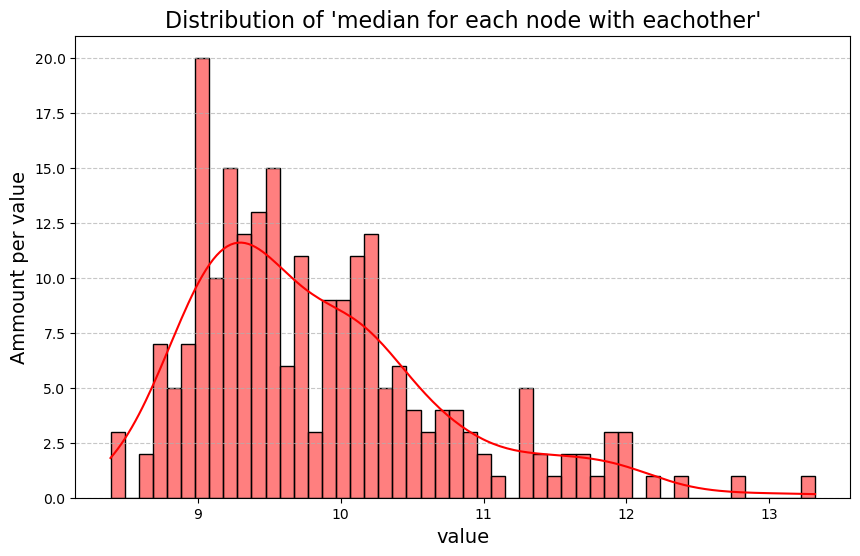

In [25]:
# https://pytorch-geometric.readthedocs.io/en/2.5.3/notes/create_dataset.html
#       data_list = [Data(...), ..., Data(...)]
#       loader = DataLoader(data_list, batch_size=32)

from matplotlib import pyplot as plt
import seaborn as sns

# This could be used for having each node as a user, not our case.

median_values = []
for n_1_index in range(datastructure.shape[0]):
    values_for_each_node = []
    for n_2_index in range(n_1_index + 1, datastructure.shape[0]):
        values_for_each_node.append(np.linalg.norm(   
            datastructure['values'].loc[n_1_index][FEATURE_TO_COMPARE] - \
            datastructure['values'].loc[n_2_index][FEATURE_TO_COMPARE]))
    # print(np.median(np.array(values_for_each_node), axis = 0))
    if len(values_for_each_node) != 0:
        median_values.append(np.median(np.array(values_for_each_node), axis = 0))

print(f"Median of median {np.median(np.array(median_values))}")
print(f"Max of median {np.max(np.array(median_values))}")
print(f"Min of median {np.min(np.array(median_values))}")

plt.figure(figsize=(10, 6))
sns.histplot(np.array(median_values), bins=50, kde=True, color="red")
plt.title("Distribution of \'median for each node with eachother\'", fontsize=16)
plt.xlabel("value", fontsize=14)
plt.ylabel("Ammount per value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Median of median 0.10171331816750076
Max of median 0.12013966356453226
Min of median 0.08578451877604457


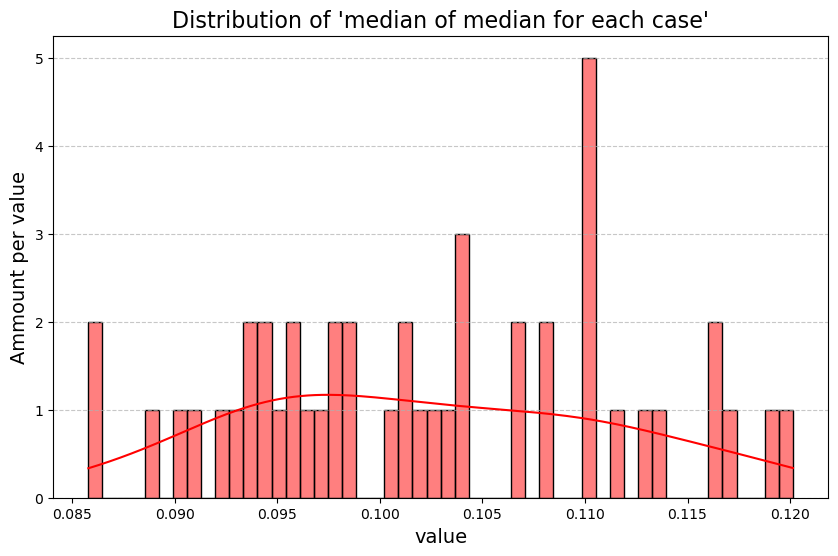

In [26]:
complete_median_for_each_case = []

# Without the step=5 the kernel crash.
for case_index in range(0, datastructure.shape[0], 5):
    values_for_each_node = []
    feature_size = datastructure['values'].loc[case_index][FEATURE_TO_COMPARE].shape[0]
    # print(feature_size) -> "14168"
    for f_1_index in range(feature_size):
        values_for_this_node = []
        for f_2_index in range(f_1_index + 1, datastructure.shape[0]):
            values_for_this_node.append(np.linalg.norm(   
                datastructure['values'].loc[case_index][FEATURE_TO_COMPARE].iloc[f_1_index] - \
                datastructure['values'].loc[case_index][FEATURE_TO_COMPARE].iloc[f_2_index]))
        if len(values_for_this_node) != 0:
            values_for_each_node.append(np.median(np.array(values_for_this_node), axis = 0))
    complete_median_for_each_case.append(np.median(np.array(values_for_each_node), axis = 0))

print(f"Median of median {np.median(np.array(complete_median_for_each_case))}")
print(f"Max of median {np.max(np.array(complete_median_for_each_case))}")
print(f"Min of median {np.min(np.array(complete_median_for_each_case))}")

plt.figure(figsize=(10, 6))
sns.histplot(np.array(complete_median_for_each_case), bins=50, kde=True, color="red")
plt.title("Distribution of \'median of median for each case\'", fontsize=16)
plt.xlabel("value", fontsize=14)
plt.ylabel("Ammount per value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [55]:
THRESHOLD = 0.1

# I'm just gonna do it for the first 30, as an example, in the deployed one
# we obviusly need to do it for all.

list_of_Data = []

for case_index in range(0, 30):
    feature_size = datastructure['values'].loc[case_index][FEATURE_TO_COMPARE].shape[0]
    edges = [[],[]]

    for f_1_index in range(feature_size):
        for f_2_index in range(f_1_index + 1, datastructure.shape[0]):
            similarity = np.linalg.norm(   
                datastructure['values'].loc[case_index][FEATURE_TO_COMPARE].iloc[f_1_index] - \
                datastructure['values'].loc[case_index][FEATURE_TO_COMPARE].iloc[f_2_index])
            if similarity <= THRESHOLD:
                edges[0].append(f_1_index)
                edges[0].append(f_2_index)
                edges[1].append(f_2_index)
                edges[1].append(f_1_index)
    
    edge_index = torch.tensor(edges, dtype=torch.long)
    x = torch.tensor(list(datastructure['values'].loc[case_index][FEATURE_TO_COMPARE]), dtype=torch.float)
    y = torch.tensor(datastructure['os'].loc[case_index])
    list_of_Data.append(Data(x=x, edge_index=edge_index, y=y))


In [28]:
G = to_networkx(list_of_Data[0], to_undirected=True)

print("Numero di nodi:", G.number_of_nodes())
print("Numero di archi:", G.number_of_edges())

# Grado di ciascun nodo (numero di connessioni per gene)
degrees = dict(G.degree())
print("Gradi dei nodi:", degrees)

# Nodo con il massimo grado (gene con più connessioni)
max_degree_node = max(degrees, key=degrees.get)
print(f"Gene con il massimo grado: {max_degree_node} ({degrees[max_degree_node]} connessioni)")

# Trova tutte le componenti connesse
connected_components = list(nx.connected_components(G))
print("Numero di componenti connesse:", len(connected_components))

Numero di nodi: 14168
Numero di archi: 9334
Gradi dei nodi: {0: 29, 1: 114, 2: 92, 3: 86, 4: 108, 5: 117, 6: 90, 7: 114, 8: 105, 9: 29, 10: 127, 11: 127, 12: 127, 13: 121, 14: 58, 15: 30, 16: 25, 17: 24, 18: 118, 19: 120, 20: 116, 21: 109, 22: 78, 23: 44, 24: 120, 25: 117, 26: 38, 27: 114, 28: 41, 29: 86, 30: 28, 31: 120, 32: 39, 33: 72, 34: 123, 35: 71, 36: 86, 37: 105, 38: 79, 39: 66, 40: 110, 41: 30, 42: 50, 43: 17, 44: 87, 45: 128, 46: 120, 47: 30, 48: 127, 49: 125, 50: 121, 51: 95, 52: 9, 53: 106, 54: 24, 55: 120, 56: 43, 57: 92, 58: 128, 59: 109, 60: 100, 61: 102, 62: 127, 63: 78, 64: 108, 65: 114, 66: 126, 67: 100, 68: 42, 69: 114, 70: 125, 71: 46, 72: 30, 73: 21, 74: 117, 75: 120, 76: 118, 77: 81, 78: 106, 79: 79, 80: 114, 81: 74, 82: 27, 83: 87, 84: 87, 85: 75, 86: 71, 87: 17, 88: 17, 89: 117, 90: 116, 91: 17, 92: 93, 93: 31, 94: 66, 95: 34, 96: 83, 97: 102, 98: 104, 99: 121, 100: 124, 101: 43, 102: 116, 103: 27, 104: 87, 105: 128, 106: 44, 107: 95, 108: 17, 109: 120, 110: 127

So now we have a list of Data.
A list of 226 Graph, one for each case.

# Split into Test and Train

### Split base on OS

In [56]:
NUMBER_OF_CLASSES = 3
PERCENTAGE_OF_TEST = 0.3

In [57]:
# First divide it in classes
os = [int(d.y) for d in list_of_Data]
os.sort()

n = len(os)

split_values = []
for c in range(1, NUMBER_OF_CLASSES + 1):
    if c == NUMBER_OF_CLASSES:
        split_values.append(os[len(os) - 1])
    else:
        index = (n // NUMBER_OF_CLASSES) * c
        split_values.append(os[index - 1])

list_data_split = []
for c in range(NUMBER_OF_CLASSES):
    list_data_split.append([])
    for d in list_of_Data:
        if  (c == 0 and int(d.y) <= split_values[c]) or \
            (c > 0 and int(d.y) <= split_values[c] and int(d.y) > split_values[c-1]):
            list_data_split[c].append(d)

In [58]:
print(f"Total dimension: {len(list_of_Data)}")
for c in range(NUMBER_OF_CLASSES):
    print(f"Class {c + 1}: {len(list_data_split[c])}")
    print("os:", end="")
    for d in list_data_split[c]:
        print(f"\t{d.y}", end="")
    print("")

print(f"\n\nComplete OS {os}")

Total dimension: 30
Class 1: 10
os:	583	189	24	83	608	379	515	562	129	186
Class 2: 10
os:	1163	871	863	1024	1104	676	788	636	1103	1089
Class 3: 10
os:	4624	1815	1355	1688	1955	2049	1484	1213	1229	2097


Complete OS [24, 83, 129, 186, 189, 379, 515, 562, 583, 608, 636, 676, 788, 863, 871, 1024, 1089, 1103, 1104, 1163, 1213, 1229, 1355, 1484, 1688, 1815, 1955, 2049, 2097, 4624]


### Now actually split in Test and Train

In [59]:
train_list = []
test_list = []

if PERCENTAGE_OF_TEST > 0:
    test_interval = np.floor(1 / PERCENTAGE_OF_TEST)
else:
    test_interval = len(list_of_Data) + 1 # we'll never reach it.
# print(test_interval)

for class_list in list_data_split:
    count = 1
    for d in class_list:
        if count >= test_interval:
            test_list.append(d)
            count = 0
        else:
            train_list.append(d)
        count += 1

In [60]:
# Check results

print("### Train ###")
for c in range(NUMBER_OF_CLASSES):
    count = 0
    for d in train_list:
        if  (c == 0 and int(d.y) <= split_values[c]) or \
            (c > 0 and int(d.y) <= split_values[c] and int(d.y) > split_values[c-1]):
            count += 1
    print(f"\tFor class {c + 1} we have {count} elements")

print("### Test ###")
for c in range(NUMBER_OF_CLASSES):
    count = 0
    for d in test_list:
        if  (c == 0 and int(d.y) <= split_values[c]) or \
            (c > 0 and int(d.y) <= split_values[c] and int(d.y) > split_values[c-1]):
            count += 1
    print(f"\tFor class {c + 1} we have {count} elements")

### Train ###
	For class 1 we have 7 elements
	For class 2 we have 7 elements
	For class 3 we have 7 elements
### Test ###
	For class 1 we have 3 elements
	For class 2 we have 3 elements
	For class 3 we have 3 elements
